In [2]:
import sys
sys.path.append('/home/kyungtak.lim/gbspy')


import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

# Get the current working directory|
cwd = os.getcwd()

In [3]:
os.chdir('/zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu1')
s=g.Sim()

t_final = s.time[-1]
t_init = t_final# - 1 

tempe = s.get_field('Te', t1=t_init, t2=t_final)
dens = s.get_field('n', t1=t_init, t2=t_final)

tempe = np.mean(dens, axis=(2,3))
dens = np.mean(dens, axis=(2,3))

# For DN
with open('equilibrium') as f:
    lines = f.readlines()
    xmag_str=lines[-5]
    y0_source_str=lines[-4]
    Yxpt_str=lines[-3]
    Yxpt1_str=lines[-2]

    
xmag_split = xmag_str.split('=')
y0_source_split = y0_source_str.split('=')
Yxpt_split = Yxpt_str.split('=')
Yxpt1_split = Yxpt1_str.split('=')


xmag = float(xmag_split[1].strip())
y0_source = float(y0_source_split[1].strip())
Yxpt = float(Yxpt_split[1].strip())
Yxpt1 = float(Yxpt1_split[1].strip())

print("xmag=", xmag)
print("y0_source=", y0_source)
print("Yxpt=", Yxpt)
print("Yxpt1=", Yxpt1)

x0n = 140#s.attribute['x0_EC_theta']
x0t = 140#s.attribute['x0_EC_tempe']


print("The position of x0n and x0t =", x0n,"/", x0t)

wn = 1500#s.attribute['wEC_theta']
wt = 1500#s.attribute['wEC_tempe']

print("The width of wn and wt =", wn,"/", wt)

# Amplitude of the source
An = s.attribute['SEC_theta']
At = 7#s.attribute['SEC_tempe']

print("The amplitude of An and At =", An,"/", At)

Psi = s.Psi
#psi0n = Psi[s.iy0, ix0n]
#psi0t = Psi[s.iy0, ix0t]

Bpol = s.dpsidx_v**2 + s.dpsidy_v**2
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), s.dpsidx_v.shape)

iyxpt = s.iyxpt
iyxpt2 = s.ny-s.iyxpt

for iy in range(0, s.ny-1):  # +1 since Python's range end is exclusive
    if s.y[iy] - y0_source <= 0 and s.y[iy + 1] - y0_source > 0:
        iysource = iy
        

# Search in xarray for ixsource
for ix in range(0, s.nx-1):
    if s.x[ix] - x0n - xmag <= 0 and s.x[ix + 1] - x0n - xmag > 0:
        ixsource_n = ix
        
for ix in range(0, s.nx-1):
    if s.x[ix] - x0t - xmag <= 0 and s.x[ix + 1] - x0t - xmag > 0:
        ixsource_t = ix
        

if iysource is not None and ixsource_n and ixsource_t is not None:
    psi_eq_n = s.Psi[iysource][ixsource_n]
    psi_eq_t = s.Psi[iysource][ixsource_t]
    
    
# Density source (Local flux)
Sn = [[0 for x in range(s.nx)] for y in range(s.ny)]
St = [[0 for x in range(s.nx)] for y in range(s.ny)]

for i in range(s.ny):
    for j in range(s.nx):
        if (s.y[i] > Yxpt) and (s.y[i]< Yxpt1):
            #Sn[i][j]= An * np.exp(-(Psi[i][j] - psi_eq_n)**2/wn**2) 
            Sn[i][j] = An/2 * (np.tanh(-(Psi[i][j] - (psi_eq_n+20))/2500) + 1)
            St[i][j] = At/2 * (np.tanh(-(Psi[i][j] - psi_eq_t)/wt) + 1)
        else:
            Sn[i][j] = 0
            St[i][j] = 0

# Power source
Sp = dens * St + tempe * Sn

xmag= 246.0
y0_source= 400.0
Yxpt= 151.25
Yxpt1= 653.75
The position of x0n and x0t = 140 / 140
The width of wn and wt = 1500 / 1500
The amplitude of An and At = 0.3 / 7


In [13]:
print(s.x[s.ix0])
print(s.y[s.iy0])

298.75
483.75


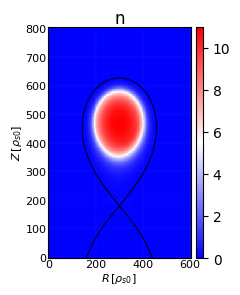

In [10]:
X, Y = np.meshgrid(s.x, s.y)
fig, ax = plt.subplots(figsize=(2, 3),  dpi=100, sharex=True, sharey=True)

cs1 = ax.pcolormesh(X, Y, Sp, cmap='bwr')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(cs1, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)


ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], linewidths=0.7, colors='k')
ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', labelsize=8, pad=1)
ax.tick_params(axis='y', labelsize=8, pad=1)
ax.tick_params(which='minor', direction="in", size=0)
ax.tick_params(which='major', direction="in", size=0)

        
ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=8, labelpad=1)


ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=8, rotation=90, labelpad=1)

ax.set_title(r'n', fontsize=12, pad=1.5)

#plt.gca().set_aspect('equal')
plt.show(block=False)

In [11]:
os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6')
#os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DPT_d0p6')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

Current working directory: /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6
An error occured when opening /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6/results_120.h5:
Unable to open file (file signature not found)
Trying to skip the file...
Last results file skipped


In [12]:
# IEEE journals typically require figures to be very clear at a column width of around 3.5 to 4 inches
fig_width = 3.5  # in inches
fig_height =  fig_width / 1.618
plt.rcParams.update({
    # Figure size and DPI
    'figure.figsize': (fig_width, fig_width / 1.618),  # IEEE column width, golden ratio height
    'figure.dpi': 300,                     # Figure resolution
    'savefig.dpi': 300,                    # Save figure resolution
    'savefig.format': 'pdf',               # Preferred format for vector graphics

    # Font settings
    'font.size': 10,                       # Main font size
    'font.family': 'Sans-serif',           # Font family
    'font.sans-serif': ['Arial', 'Helvetica'],  # Font type

    # Axes settings
    'axes.labelsize': 10,                  # Font size of the x and y labels
    'axes.titlesize': 10,                  # Font size of the title
    'axes.linewidth': 1,                   # Edge line width

    # Tick settings
    'xtick.labelsize': 10,                  # Font size of the x tick labels
    'ytick.labelsize': 10,                  # Font size of the y tick labels
    'xtick.major.size': 4,                 # Length of major tick marks
    'xtick.minor.size': 2,                 # Length of minor tick marks
    'xtick.major.width': 1,                # Width of major tick marks
    'xtick.minor.width': 0.5,              # Width of minor tick marks
    'ytick.major.size': 4,                 # Length of major tick marks
    'ytick.minor.size': 2,                 # Length of minor tick marks
    'ytick.major.width': 1,                # Width of major tick marks
    'ytick.minor.width': 0.5,              # Width of minor tick marks

    # Legend settings
    'legend.fontsize': 12,                  # Font size of the legend
    'legend.frameon': True,               # Disable background frame
    'legend.edgecolor':'white',

    # Line settings
    'lines.linewidth': 1.5,                # Line width
    'lines.markersize': 4,                 # Marker size
    'lines.markeredgewidth' : 0.8,
    'lines.markeredgecolor' : 'black',
    # Grid settings
    'grid.alpha': 0.5,                     # Grid line transparency
    'grid.linestyle': ':',                 # Grid line style
    
    # Scatter settings
    'scatter.edgecolors': None,
    
    # Marker
    'lines.markeredgewidth' : 5,
    'lines.markeredgecolor' : 'black'

})

<div class="alert alert-block alert-info" style="text-align: center;">
<span style="font-size: 40px;"><b> Figures </b></span><br><br>
<span style="font-size: 16px;">
- PT 0.6 separatrix x=510 <br> 
- NT -0.6 separatrix x=420 <br> 
    </span>
</div>

In [37]:
os.chdir('/marconi_work/FUA37_TSVV2/kyungtak/GBS_DN/DN_tria/delta_scan/DNT_dn0p6')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()
# Time setting for the plots, i.e. t2=the last time, t1= t2-10
t2=s.time[-1]
t1=t2-10

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]

Psi_DNT = s.Psi; ixxpt_DNT = s.ixxpt; iyxpt_DNT = s.iyxpt

# Load field
dens  = s.get_field('n',     z1=z1, z2=z2, t1=t1, t2=t2)
Te    = s.get_field('Te', z1=z1, z2=z2, t1=t1, t2=t2)
phi    = s.get_field('strmf', z1=z1, z2=z2, t1=t1, t2=t2)
pe    = dens * Te

# Average in time and toroidal direction
dens_DNT_d0p6_avg  = np.mean(dens, axis=(2,3)); dens_avg_tor = np.mean(dens, axis=2)
pe_DNT_d0p6_avg  = np.mean(pe, axis=(2,3)); pe_avg_tor = np.mean(pe, axis=2)
Te_DNT_d0p6_avg    = np.mean(Te, axis=(2,3)); Te_avg_tor = np.mean(Te, axis=2)
phi_DNT_d0p6_avg    = np.mean(phi, axis=(2,3)); phi_avg_tor = np.mean(phi, axis=2)

dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
dens_DNT_d0p6_fluct_avg = np.mean(dens_fluct, axis=2)

pe_fluct   = np.sqrt((pe[:,:,0,:]-pe_avg_tor)**2) / pe_avg_tor
pe_DNT_d0p6_fluct_avg = np.mean(pe_fluct, axis=2)

Te_fluct   = np.sqrt((Te[:,:,0,:]-Te_avg_tor)**2) / Te_avg_tor
Te_DNT_d0p6_fluct_avg = np.mean(Te_fluct, axis=2)

phi_fluct   = np.sqrt((phi[:,:,0,:]-phi_avg_tor)**2) / phi_avg_tor
phi_DNT_d0p6_fluct_avg = np.mean(phi_fluct, axis=2)

phi_fluct_d0p6 = phi[:,:,0,-1]

Current working directory: /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6


In [38]:
from gbspy.surfaces import get_line

UO_DNT_dn0p6=(456.5503784658009, 709.075944151039)
UI_DNT_dn0p6=(310.36118514691896, 721.6963043686486)
LI_DNT_dn0p6=(310.3629879445284, 78.30729369710014)
LO_DNT_dn0p6=(456.5471511382758, 90.92656834368125)

coord_UI_DNT_dn0p6, length_UI_DNT_dn0p6 = get_line(s, UI_DNT_dn0p6, (-40,40), "psi", resolution=(40,40))
coord_UO_DNT_dn0p6, length_UO_DNT_dn0p6 = get_line(s, UO_DNT_dn0p6, (-40,40), "psi", resolution=(40,40))
coord_LI_DNT_dn0p6, length_LI_DNT_dn0p6 = get_line(s, LI_DNT_dn0p6, (-40,40), "psi", resolution=(40,40))
coord_LO_DNT_dn0p6, length_LO_DNT_dn0p6 = get_line(s, LO_DNT_dn0p6, (-40,40), "psi", resolution=(40,40))

In [39]:
os.chdir('/marconi_work/FUA37_TSVV2/kyungtak/GBS_DN/DN_tria/delta_scan/DPT_d0p6')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()
# Time setting for the plots, i.e. t2=the last time, t1= t2-10
t2=s.time[-1]
t1=t2-10

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]

Psi_DPT = s.Psi; ixxpt_DPT = s.ixxpt; iyxpt_DPT = s.iyxpt

# Load field
dens  = s.get_field('n',     z1=z1, z2=z2, t1=t1, t2=t2)
Te    = s.get_field('Te', z1=z1, z2=z2, t1=t1, t2=t2)
phi    = s.get_field('strmf', z1=z1, z2=z2, t1=t1, t2=t2)
pe    = dens * Te

# Average in time and toroidal direction
dens_DPT_d0p6_avg  = np.mean(dens, axis=(2,3)); dens_avg_tor = np.mean(dens, axis=2)
pe_DPT_d0p6_avg  = np.mean(pe, axis=(2,3)); pe_avg_tor = np.mean(pe, axis=2)
Te_DPT_d0p6_avg    = np.mean(Te, axis=(2,3)); Te_avg_tor = np.mean(Te, axis=2)

dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
dens_DPT_d0p6_fluct_avg = np.mean(dens_fluct, axis=2)

pe_fluct   = np.sqrt((pe[:,:,0,:]-pe_avg_tor)**2) / pe_avg_tor
pe_DPT_d0p6_fluct_avg = np.mean(pe_fluct, axis=2)

Te_fluct   = np.sqrt((Te[:,:,0,:]-Te_avg_tor)**2) / Te_avg_tor
Te_DPT_d0p6_fluct_avg = np.mean(Te_fluct, axis=2)

phi_fluct_d0p6 = phi[:,:,0,-1]

Current working directory: /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6


In [40]:
from gbspy.surfaces import get_line
# For balanced DN
UI_DPT_d0p6=(158.85261121620908, 709.7637771419237)
UO_DPT_d0p6=(305.110743051502, 721.353638088224)
LI_DPT_d0p6=(158.85475695604873, 90.23778669576583)
LO_DPT_d0p6=(305.11048564829156, 78.6468451190245)


coord_UI_DPT_d0p6, length_UI_DPT_d0p6 = get_line(s, UI_DPT_d0p6, (-40,40), "psi", resolution=(40,40))
coord_UO_DPT_d0p6, length_UO_DPT_d0p6 = get_line(s, UO_DPT_d0p6, (-40,40), "psi", resolution=(40,40))
coord_LI_DPT_d0p6, length_LI_DPT_d0p6 = get_line(s, LI_DPT_d0p6, (-40,40), "psi", resolution=(40,40))
coord_LO_DPT_d0p6, length_LO_DPT_d0p6 = get_line(s, LO_DPT_d0p6, (-40,40), "psi", resolution=(40,40))

Text(0.5, 1.0, '$\\tilde{n}/\\bar{n}$')

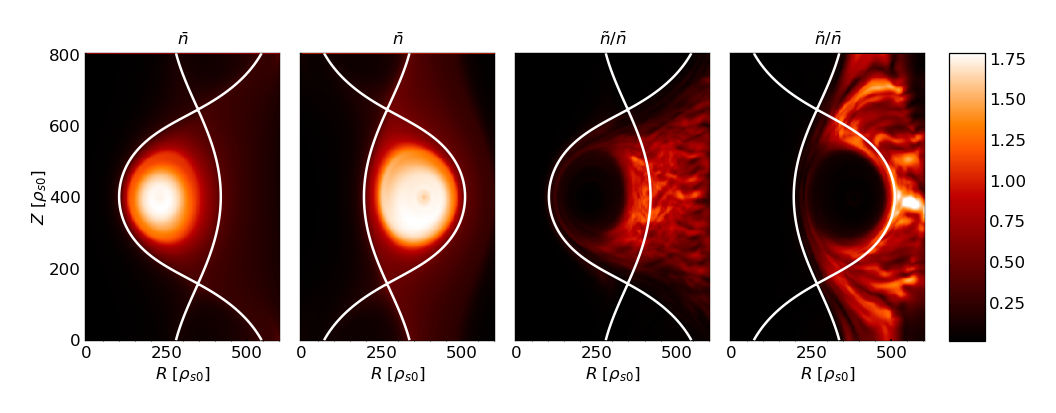

In [41]:
fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(4,1.2), dpi=300)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
X,Y = np.meshgrid(s.x, s.y)

vmin=0; vmax=0.4

# Colormap list : gist_heat, inferno, viridis, seismic, coolwarm

cs0=ax[0].pcolormesh(X, Y, dens_DNT_d0p6_avg, cmap='gist_heat')
cs1=ax[1].pcolormesh(X, Y, dens_DPT_d0p6_avg, cmap='gist_heat')
cs2=ax[2].pcolormesh(X, Y, dens_DNT_d0p6_fluct_avg, cmap='gist_heat', vmin=vmin, vmax=vmax)
cs3=ax[3].pcolormesh(X, Y, dens_DPT_d0p6_fluct_avg, cmap='gist_heat', vmin=vmin, vmax=vmax)


# Colorbar 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.03, 0.8])

cbar = fig.colorbar(cs1, cax=cbar_ax)
cbar.ax.tick_params(labelsize=4, size=0, pad=1) 
cbar.outline.set_linewidth(0.3)


ax[0].set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=4, rotation=90, labelpad=0)
Psi_USN = s.Psi; ixxpt_USN = s.ixxpt; iyxpt_USN = s.iyxpt

ax[0].contour(X, Y, Psi_DNT, levels=[Psi_DNT[iyxpt_DNT, ixxpt_DNT]], colors='w', linewidths=0.6, linestyles='-')
ax[1].contour(X, Y, Psi_DPT, levels=[Psi_DPT[iyxpt_DPT, ixxpt_DPT]], colors='w', linewidths=0.6, linestyles='-')
ax[2].contour(X, Y, Psi_DNT, levels=[Psi_DNT[iyxpt_DNT, ixxpt_DNT]], colors='w', linewidths=0.6, linestyles='-')
ax[3].contour(X, Y, Psi_DPT, levels=[Psi_DPT[iyxpt_DPT, ixxpt_DPT]], colors='w', linewidths=0.6, linestyles='-')

for i in range(4):
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].tick_params(which='minor', direction="in", size=0.2, width=0.2)
    ax[i].tick_params(which='major', direction="in", size=0.5, width=0.4)
    ax[i].tick_params(axis='x', labelsize=4, pad=1)
    ax[i].tick_params(axis='y', labelsize=4, pad=1)
    ax[i].set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=4, labelpad=1)
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.1)

ax[0].set_title(r'$\bar{n}$', size=4, pad=2)
ax[1].set_title(r'$\bar{n}$', size=4, pad=2)
ax[2].set_title(r'$\tilde{n}/\bar{n}$', size=4, pad=2)
ax[3].set_title(r'$\tilde{n}/\bar{n}$', size=4, pad=2)

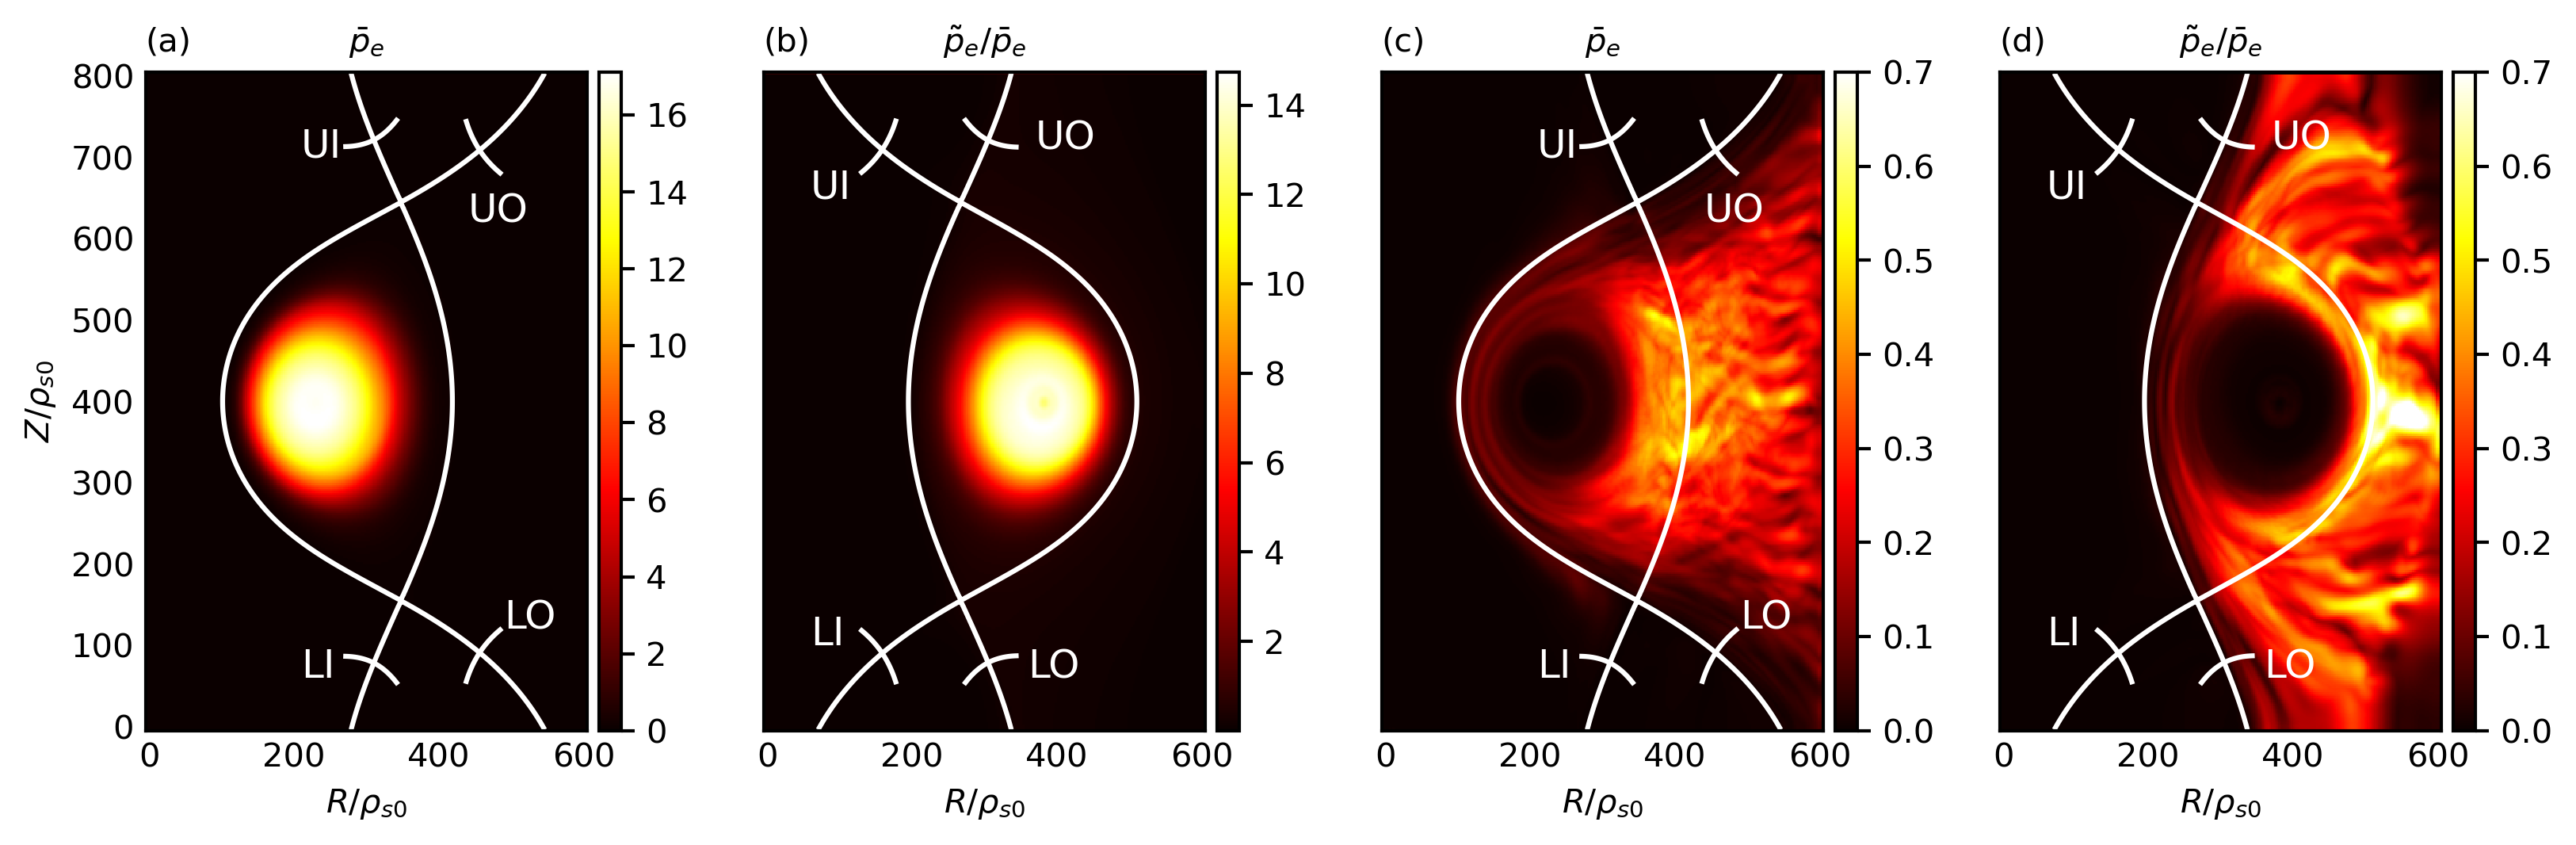

In [42]:
# Assuming 's' is a predefined object with attributes like 'x', 'y', 'Psi', etc.

X, Y = np.meshgrid(s.x, s.y)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(3.5*fig_width, 1.6*fig_height), sharex=True, sharey=True, dpi=300)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)

# Example data for color_maps
titles = [r'$\bar{p}_e$', r'$\tilde{p}_e/\bar{p}_e$', r'$\bar{p}_e}$', r'$\tilde{p}_{e}/\bar{p}_e$']


#cs0 = ax[0].pcolormesh(X, Y, pe_DNTnu0p3_avg, cmap='seismic', rasterized=True)
cs0 = ax[0].pcolormesh(X, Y, Sp, cmap='hot', rasterized=True)
divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes('right', size='5%', pad=0.05)
cbar0 = fig.colorbar(cs0, cax=cax0, orientation='vertical')
cbar0.ax.tick_params(labelsize=10)  # Adjusted size

cs1 = ax[1].pcolormesh(X, Y, pe_DPT_d0p6_avg, cmap='hot', rasterized=True)
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(cs1, cax=cax1, orientation='vertical')
cbar1.ax.tick_params(labelsize=10)  # Adjusted size

cs2 = ax[2].pcolormesh(X, Y, pe_DNT_d0p6_fluct_avg, cmap='hot', vmin=0., vmax=0.7, rasterized=True)
divider = make_axes_locatable(ax[2])
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(cs2, cax=cax2, orientation='vertical')
cbar2.ax.tick_params(labelsize=10)  # Adjusted size

cs3 = ax[3].pcolormesh(X, Y, pe_DPT_d0p6_fluct_avg, cmap='hot', vmin=0., vmax=0.7, rasterized=True)
divider = make_axes_locatable(ax[3])
cax3 = divider.append_axes('right', size='5%', pad=0.05)
cbar3 = fig.colorbar(cs3, cax=cax3, orientation='vertical')
cbar3.ax.tick_params(labelsize=10)  # Adjusted size

ax[0].contour(X, Y, Psi_DNT, levels=[Psi_DNT[iyxpt_DNT, ixxpt_DNT]], colors='w')
ax[1].contour(X, Y, Psi_DPT, levels=[Psi_DPT[iyxpt_DPT, ixxpt_DPT]], colors='w')
ax[2].contour(X, Y, Psi_DNT, levels=[Psi_DNT[iyxpt_DNT, ixxpt_DNT]], colors='w')
ax[3].contour(X, Y, Psi_DPT, levels=[Psi_DPT[iyxpt_DPT, ixxpt_DPT]], colors='w')
#ax[1].axvline(x=510, lw=1, c='w', ls='--')

for i in [0,2]:
    ax[i].plot(coord_UI_DNT_dn0p6[0,:], coord_UI_DNT_dn0p6[1,:], c='w')
    ax[i].plot(coord_UO_DNT_dn0p6[0,:], coord_UO_DNT_dn0p6[1,:], c='w')
    ax[i].plot(coord_LI_DNT_dn0p6[0,:], coord_LI_DNT_dn0p6[1,:], c='w')
    ax[i].plot(coord_LO_DNT_dn0p6[0,:], coord_LO_DNT_dn0p6[1,:], c='w')
    ax[i].text(490, 120, 'LO',  fontsize = 12, color ="w")
    ax[i].text(210, 60, 'LI',  fontsize = 12, color ="w")
    ax[i].text(440, 620, 'UO', fontsize = 12, color ="w")
    ax[i].text(210, 700, 'UI', fontsize = 12, color ="w")
    
for i in [1,3]:
    ax[i].plot(coord_UI_DPT_d0p6[0,:], coord_UI_DPT_d0p6[1,:], c='w')
    ax[i].plot(coord_UO_DPT_d0p6[0,:], coord_UO_DPT_d0p6[1,:], c='w')
    ax[i].plot(coord_LI_DPT_d0p6[0,:], coord_LI_DPT_d0p6[1,:], c='w')
    ax[i].plot(coord_LO_DPT_d0p6[0,:], coord_LO_DPT_d0p6[1,:], c='w')

    ax[i].text(360, 60, 'LO', fontsize = 12, color ="w")
    ax[i].text(60, 100, 'LI',  fontsize = 12, color ="w")
    ax[i].text(370, 710, 'UO', fontsize = 12, color ="w")
    ax[i].text(60, 650, 'UI', fontsize = 12, color ="w")

for i in range(4):
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].tick_params(axis='both', which='both', direction="in", size=0.5)  # Adjusted size
    ax[i].set_xlabel(r'$R /\rho_{s0}$')
    ax[i].set_title(titles[i])

ax[0].set_ylabel(r'$Z/\rho_{s0}$',rotation=90)
#plt.show()
ax[0].text(0.0, 1.07, '(a)', transform=ax[0].transAxes, c='k', verticalalignment='top')
ax[1].text(0.0, 1.07, '(b)', transform=ax[1].transAxes, c='k', verticalalignment='top')
ax[2].text(0.0, 1.07, '(c)', transform=ax[2].transAxes, c='k', verticalalignment='top')
ax[3].text(0.0, 1.07, '(d)', transform=ax[3].transAxes, c='k', verticalalignment='top')


# Save the figure
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("Snapshot.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=300)

<div class="alert alert-block alert-info" style="text-align: center;">
<span style="font-size: 40px;"><b> Figures case with $\nu=0.1$ </b></span><br>
</div>

In [19]:
os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/nu_scan/DNT_nu0p1')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()
# Time setting for the plots, i.e. t2=the last time, t1= t2-10
t2=s.time[-1]
t1=t2

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]

Psi_DNT = s.Psi; ixxpt_DNT = s.ixxpt; iyxpt_DNT = s.iyxpt

# Load field
dens  = s.get_field('n',     z1=z1, z2=z2, t1=t1, t2=t2)
Te    = s.get_field('Te', z1=z1, z2=z2, t1=t1, t2=t2)
pe    = dens * Te

# Average in time and toroidal direction
dens_avg  = np.mean(dens, axis=(2,3)); dens_avg_tor = np.mean(dens, axis=2)
pe_avg  = np.mean(pe, axis=(2,3)); pe_avg_tor = np.mean(pe, axis=2)
Te_avg    = np.mean(Te, axis=(2,3)); Te_avg_tor = np.mean(Te, axis=2)

dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
dens_DNTnu0p1_fluct_avg = np.mean(dens_fluct, axis=2)

pe_fluct   = np.sqrt((pe[:,:,0,:]-pe_avg_tor)**2) / pe_avg_tor
pe_DNTnu0p1_fluct_avg = np.mean(pe_fluct, axis=2)

Te_fluct   = np.sqrt((Te[:,:,0,:]-Te_avg_tor)**2) / Te_avg_tor
Te_DNTnu0p1_fluct_avg = np.mean(Te_fluct, axis=2)

Current working directory: /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6


In [20]:
os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/nu_scan/DPT_nu0p1')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()
# Time setting for the plots, i.e. t2=the last time, t1= t2-10
t2=s.time[-1]
t1=t2

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]

Psi_DPT = s.Psi; ixxpt_DPT = s.ixxpt; iyxpt_DPT = s.iyxpt

# Load field
dens  = s.get_field('n',     z1=z1, z2=z2, t1=t1, t2=t2)
Te    = s.get_field('Te', z1=z1, z2=z2, t1=t1, t2=t2)
pe    = dens * Te

# Average in time and toroidal direction
dens_avg  = np.mean(dens, axis=(2,3)); dens_avg_tor = np.mean(dens, axis=2)
pe_avg  = np.mean(pe, axis=(2,3)); pe_avg_tor = np.mean(pe, axis=2)
Te_avg    = np.mean(Te, axis=(2,3)); Te_avg_tor = np.mean(Te, axis=2)

dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
dens_DPTnu0p1_fluct_avg = np.mean(dens_fluct, axis=2)

pe_fluct   = np.sqrt((pe[:,:,0,:]-pe_avg_tor)**2) / pe_avg_tor
pe_DPTnu0p1_fluct_avg = np.mean(pe_fluct, axis=2)

Te_fluct   = np.sqrt((Te[:,:,0,:]-Te_avg_tor)**2) / Te_avg_tor
Te_DPTnu0p1_fluct_avg = np.mean(Te_fluct, axis=2)

Current working directory: /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6


Text(0.5, 1.0, '$\\tilde{n}/\\bar{n}$')

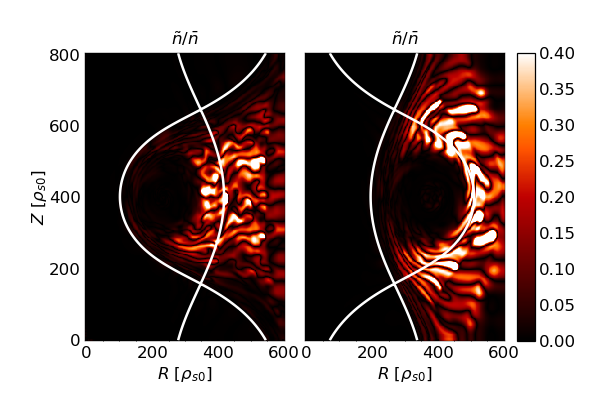

In [21]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(2,1.2), dpi=300)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
X,Y = np.meshgrid(s.x, s.y)

vmin=0; vmax=0.4

# Colormap list : gist_heat, inferno, viridis, seismic, coolwarm

cs0=ax[0].pcolormesh(X, Y, dens_DNTnu0p1_fluct_avg, cmap='gist_heat', vmin=vmin, vmax=vmax)
cs1=ax[1].pcolormesh(X, Y, dens_DPTnu0p1_fluct_avg, cmap='gist_heat', vmin=vmin, vmax=vmax)


# Colorbar 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.03, 0.8])

cbar = fig.colorbar(cs1, cax=cbar_ax)
cbar.ax.tick_params(labelsize=4, size=0, pad=1) 
cbar.outline.set_linewidth(0.3)


ax[0].set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=4, rotation=90, labelpad=0)
Psi_USN = s.Psi; ixxpt_USN = s.ixxpt; iyxpt_USN = s.iyxpt

ax[0].contour(X, Y, Psi_DNT, levels=[Psi_DNT[iyxpt_DNT, ixxpt_DNT]], colors='w', linewidths=0.6, linestyles='-')
ax[1].contour(X, Y, Psi_DPT, levels=[Psi_DPT[iyxpt_DPT, ixxpt_DPT]], colors='w', linewidths=0.6, linestyles='-')

for i in range(2):
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].tick_params(which='minor', direction="in", size=0.2, width=0.2)
    ax[i].tick_params(which='major', direction="in", size=0.5, width=0.4)
    ax[i].tick_params(axis='x', labelsize=4, pad=1)
    ax[i].tick_params(axis='y', labelsize=4, pad=1)
    ax[i].set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=4, labelpad=1)
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.1)

ax[0].set_title(r'$\tilde{n}/\bar{n}$', size=4, pad=2)
ax[1].set_title(r'$\tilde{n}/\bar{n}$', size=4, pad=2)

<div class="alert alert-block alert-info" style="text-align: center;">
<span style="font-size: 40px;"><b> Figures case with $\nu=1.0$ </b></span><br>
</div>

In [22]:
os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/nu_scan/DNT_nu1')
#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/nu_scan/DPT_nu1')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()
# Time setting for the plots, i.e. t2=the last time, t1= t2-10
t2=s.time[-1]
t1=t2

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]

Psi_DNT = s.Psi; ixxpt_DNT = s.ixxpt; iyxpt_DNT = s.iyxpt

# Load field
dens  = s.get_field('n',     z1=z1, z2=z2, t1=t1, t2=t2)
Te    = s.get_field('Te', z1=z1, z2=z2, t1=t1, t2=t2)
pe    = dens * Te

# Average in time and toroidal direction
dens_DNTnu1_avg  = np.mean(dens, axis=(2,3)); dens_avg_tor = np.mean(dens, axis=2)
pe_DNTnu1_avg  = np.mean(pe, axis=(2,3)); pe_avg_tor = np.mean(pe, axis=2)
Te_DNTnu1_avg    = np.mean(Te, axis=(2,3)); Te_avg_tor = np.mean(Te, axis=2)

dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
dens_DNTnu1_fluct_avg = np.mean(dens_fluct, axis=2)

pe_fluct   = np.sqrt((pe[:,:,0,:]-pe_avg_tor)**2) / pe_avg_tor
pe_DNTnu1_fluct_avg = np.mean(pe_fluct, axis=2)

Te_fluct   = np.sqrt((Te[:,:,0,:]-Te_avg_tor)**2) / Te_avg_tor
Te_DNTnu1_fluct_avg = np.mean(Te_fluct, axis=2)

Current working directory: /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6
An error occured when opening /marconi_scratch/userexternal/klim0000/GBS/DN_tria/nu_scan/DNT_nu1/results_112.h5:
Unable to open file (file signature not found)
Trying to skip the file...
Last results file skipped


In [23]:
os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/nu_scan/DPT_nu1')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()
# Time setting for the plots, i.e. t2=the last time, t1= t2-10
t2=s.time[-1]
t1=t2

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]

Psi_DPT = s.Psi; ixxpt_DPT = s.ixxpt; iyxpt_DPT = s.iyxpt

# Load field
dens  = s.get_field('n',     z1=z1, z2=z2, t1=t1, t2=t2)
Te    = s.get_field('Te', z1=z1, z2=z2, t1=t1, t2=t2)
pe    = dens * Te

# Average in time and toroidal direction
dens_DPTnu1_avg  = np.mean(dens, axis=(2,3)); dens_avg_tor = np.mean(dens, axis=2)
pe_DPTnu1_avg  = np.mean(pe, axis=(2,3)); pe_avg_tor = np.mean(pe, axis=2)
Te_DPTnu1_avg    = np.mean(Te, axis=(2,3)); Te_avg_tor = np.mean(Te, axis=2)

dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
dens_DPTnu1_fluct_avg = np.mean(dens_fluct, axis=2)

pe_fluct   = np.sqrt((pe[:,:,0,:]-pe_avg_tor)**2) / pe_avg_tor
pe_DPTnu1_fluct_avg = np.mean(pe_fluct, axis=2)

Te_fluct   = np.sqrt((Te[:,:,0,:]-Te_avg_tor)**2) / Te_avg_tor
Te_DPTnu1_fluct_avg = np.mean(Te_fluct, axis=2)


Current working directory: /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6
An error occured when opening /marconi_scratch/userexternal/klim0000/GBS/DN_tria/nu_scan/DPT_nu1/results_88.h5:
Unable to open file (file signature not found)
Trying to skip the file...
Last results file skipped


Text(0.5, 1.0, '$\\tilde{n}/\\bar{n}$')

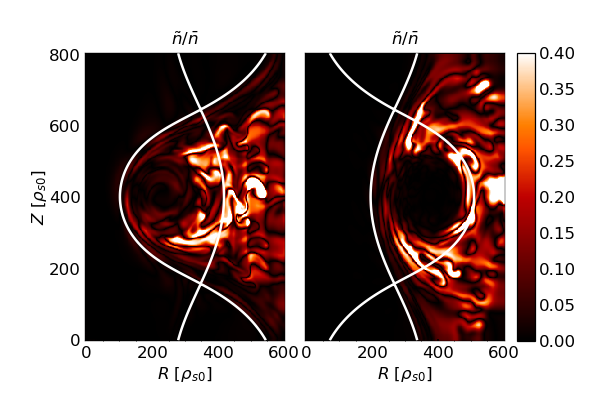

In [24]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(2,1.2), dpi=300)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
X,Y = np.meshgrid(s.x, s.y)

vmin=0; vmax=0.4

# Colormap list : gist_heat, inferno, viridis, seismic, coolwarm

cs0=ax[0].pcolormesh(X, Y, dens_DNTnu1_fluct_avg, cmap='gist_heat', vmin=vmin, vmax=vmax)
cs1=ax[1].pcolormesh(X, Y, dens_DPTnu1_fluct_avg, cmap='gist_heat', vmin=vmin, vmax=vmax)


# Colorbar 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.03, 0.8])

cbar = fig.colorbar(cs1, cax=cbar_ax)
cbar.ax.tick_params(labelsize=4, size=0, pad=1) 
cbar.outline.set_linewidth(0.3)


ax[0].set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=4, rotation=90, labelpad=0)
Psi_USN = s.Psi; ixxpt_USN = s.ixxpt; iyxpt_USN = s.iyxpt

ax[0].contour(X, Y, Psi_DNT, levels=[Psi_DNT[iyxpt_DNT, ixxpt_DNT]], colors='w', linewidths=0.6, linestyles='-')
ax[1].contour(X, Y, Psi_DPT, levels=[Psi_DPT[iyxpt_DPT, ixxpt_DPT]], colors='w', linewidths=0.6, linestyles='-')

for i in range(2):
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].tick_params(which='minor', direction="in", size=0.2, width=0.2)
    ax[i].tick_params(which='major', direction="in", size=0.5, width=0.4)
    ax[i].tick_params(axis='x', labelsize=4, pad=1)
    ax[i].tick_params(axis='y', labelsize=4, pad=1)
    ax[i].set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=4, labelpad=1)
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.1)

ax[0].set_title(r'$\tilde{n}/\bar{n}$', size=4, pad=2)
ax[1].set_title(r'$\tilde{n}/\bar{n}$', size=4, pad=2)

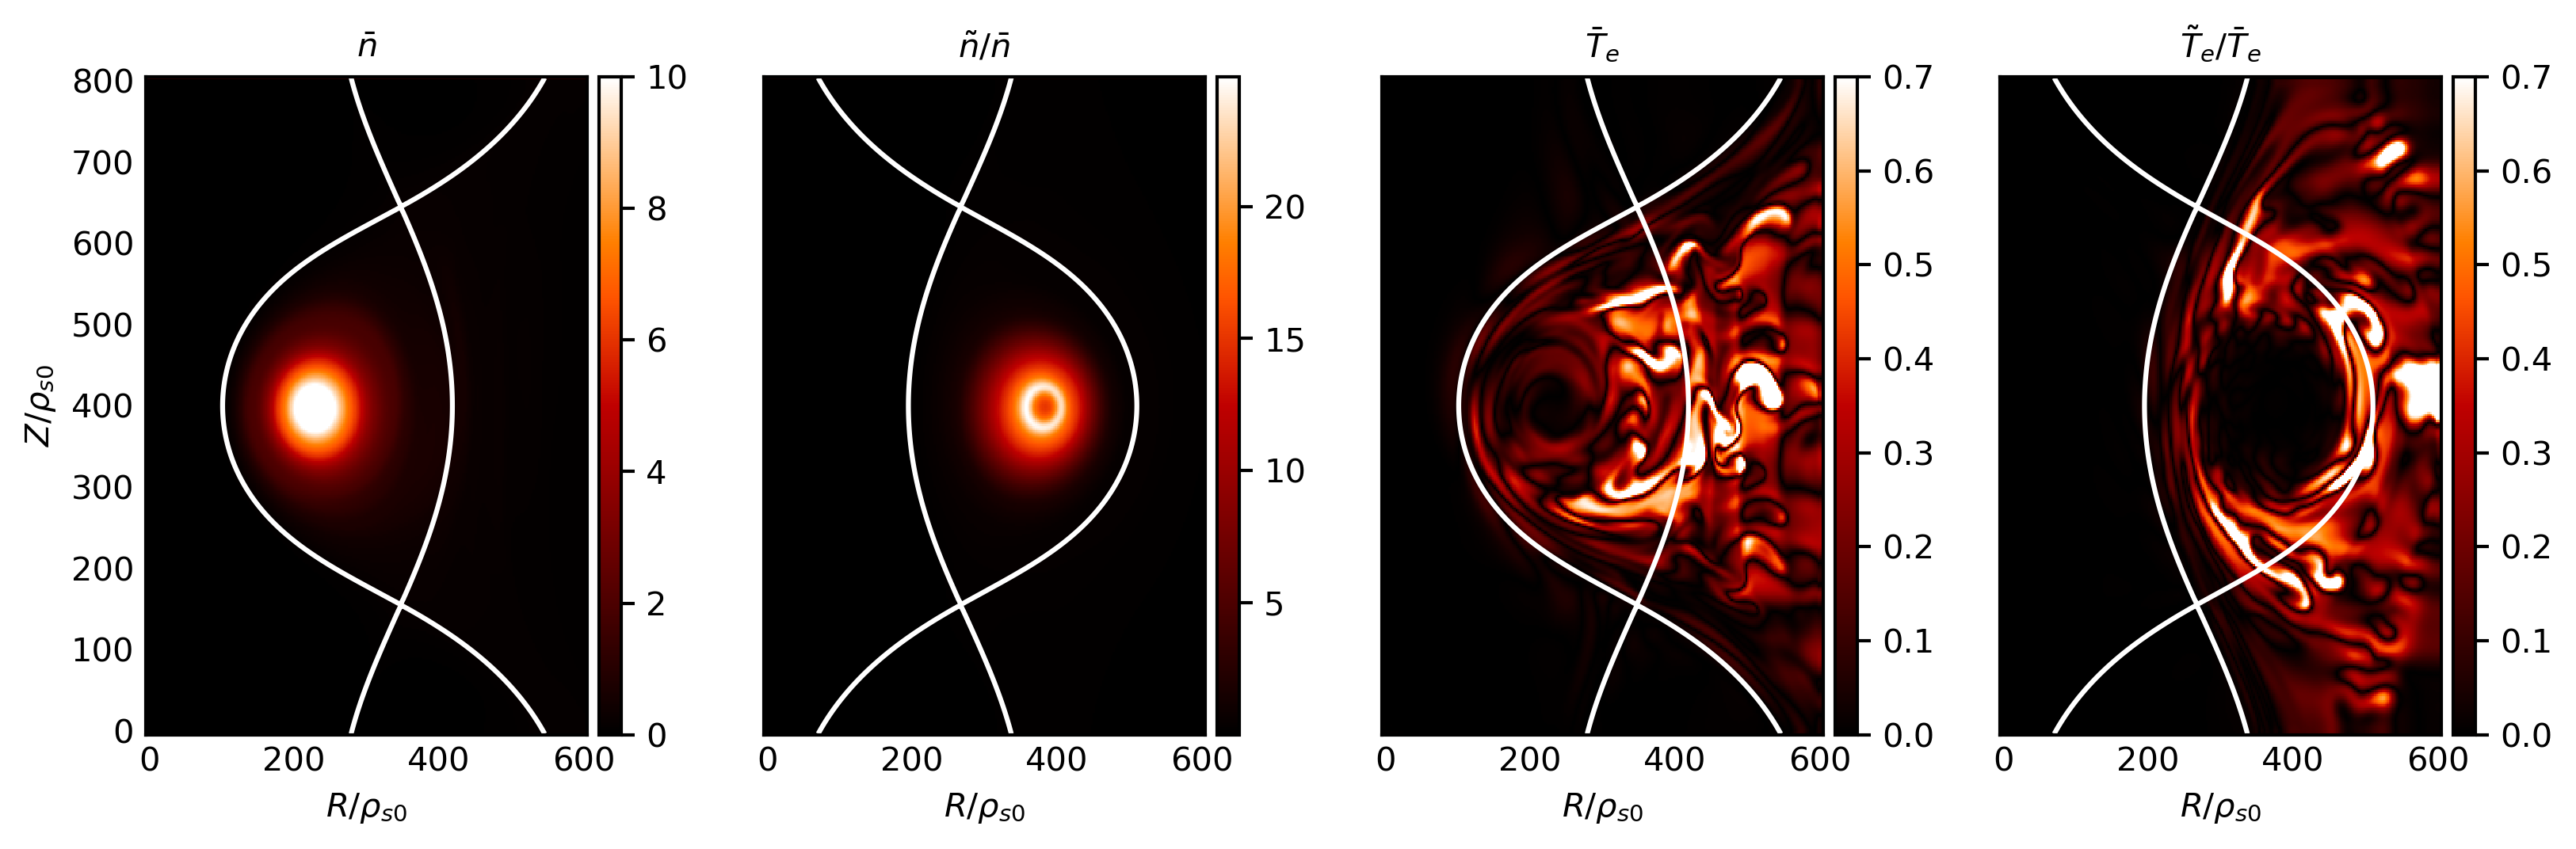

In [25]:
# Assuming 's' is a predefined object with attributes like 'x', 'y', 'Psi', etc.

X, Y = np.meshgrid(s.x, s.y)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(3.5*fig_width, 1.6*fig_height), sharex=True, sharey=True, dpi=300)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)

# Example data for color_maps
titles = [r'$\bar{n}$', r'$\tilde{n}/\bar{n}$', r'$\bar{T}_e}$', r'$\tilde{T}_{e}/\bar{T}_e$']


cs0 = ax[0].pcolormesh(X, Y, pe_DNTnu1_avg, cmap='gist_heat', vmin=0., vmax=10, rasterized=True)
divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes('right', size='5%', pad=0.05)
cbar0 = fig.colorbar(cs0, cax=cax0, orientation='vertical')
cbar0.ax.tick_params(labelsize=10)  # Adjusted size

cs1 = ax[1].pcolormesh(X, Y, pe_DPTnu1_avg, cmap='gist_heat', rasterized=True)
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(cs1, cax=cax1, orientation='vertical')
cbar1.ax.tick_params(labelsize=10)  # Adjusted size

cs2 = ax[2].pcolormesh(X, Y, pe_DNTnu1_fluct_avg, cmap='gist_heat', vmin=0., vmax=0.7, rasterized=True)
divider = make_axes_locatable(ax[2])
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(cs2, cax=cax2, orientation='vertical')
cbar2.ax.tick_params(labelsize=10)  # Adjusted size

cs3 = ax[3].pcolormesh(X, Y, pe_DPTnu1_fluct_avg, cmap='gist_heat', vmin=0., vmax=0.7, rasterized=True)
divider = make_axes_locatable(ax[3])
cax3 = divider.append_axes('right', size='5%', pad=0.05)
cbar3 = fig.colorbar(cs3, cax=cax3, orientation='vertical')
cbar3.ax.tick_params(labelsize=10)  # Adjusted size

ax[0].contour(X, Y, Psi_DNT, levels=[Psi_DNT[iyxpt_DNT, ixxpt_DNT]], colors='w')
ax[1].contour(X, Y, Psi_DPT, levels=[Psi_DPT[iyxpt_DPT, ixxpt_DPT]], colors='w')
ax[2].contour(X, Y, Psi_DNT, levels=[Psi_DNT[iyxpt_DNT, ixxpt_DNT]], colors='w')
ax[3].contour(X, Y, Psi_DPT, levels=[Psi_DPT[iyxpt_DPT, ixxpt_DPT]], colors='w')
for i in range(4):
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].tick_params(axis='both', which='both', direction="in", size=0.5)  # Adjusted size
    ax[i].set_xlabel(r'$R /\rho_{s0}$')
    ax[i].set_title(titles[i])

ax[0].set_ylabel(r'$Z/\rho_{s0}$',rotation=90)
#plt.show()

# Save the figure
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("Snapshot.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=300)

<div class="alert alert-block alert-info" style="text-align: center;">
<span style="font-size: 40px;"><b> Functions </b></span><br>
</div>

In [26]:
# Function to set up the axes with the desired settings
def setup_axes(ax, title, xlabel, ylabel=None):
    ax.set_title(title, size=4, pad=2)
    ax.set_xlabel(xlabel, fontsize=4, labelpad=1)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=4, rotation=90, labelpad=0)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', direction="in", size=0.2, width=0.2)
    ax.tick_params(which='major', direction="in", size=0.5, width=0.4)
    ax.tick_params(axis='both', labelsize=4, pad=1)
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)

NameError: name 'dens_DN_fluct_avg' is not defined

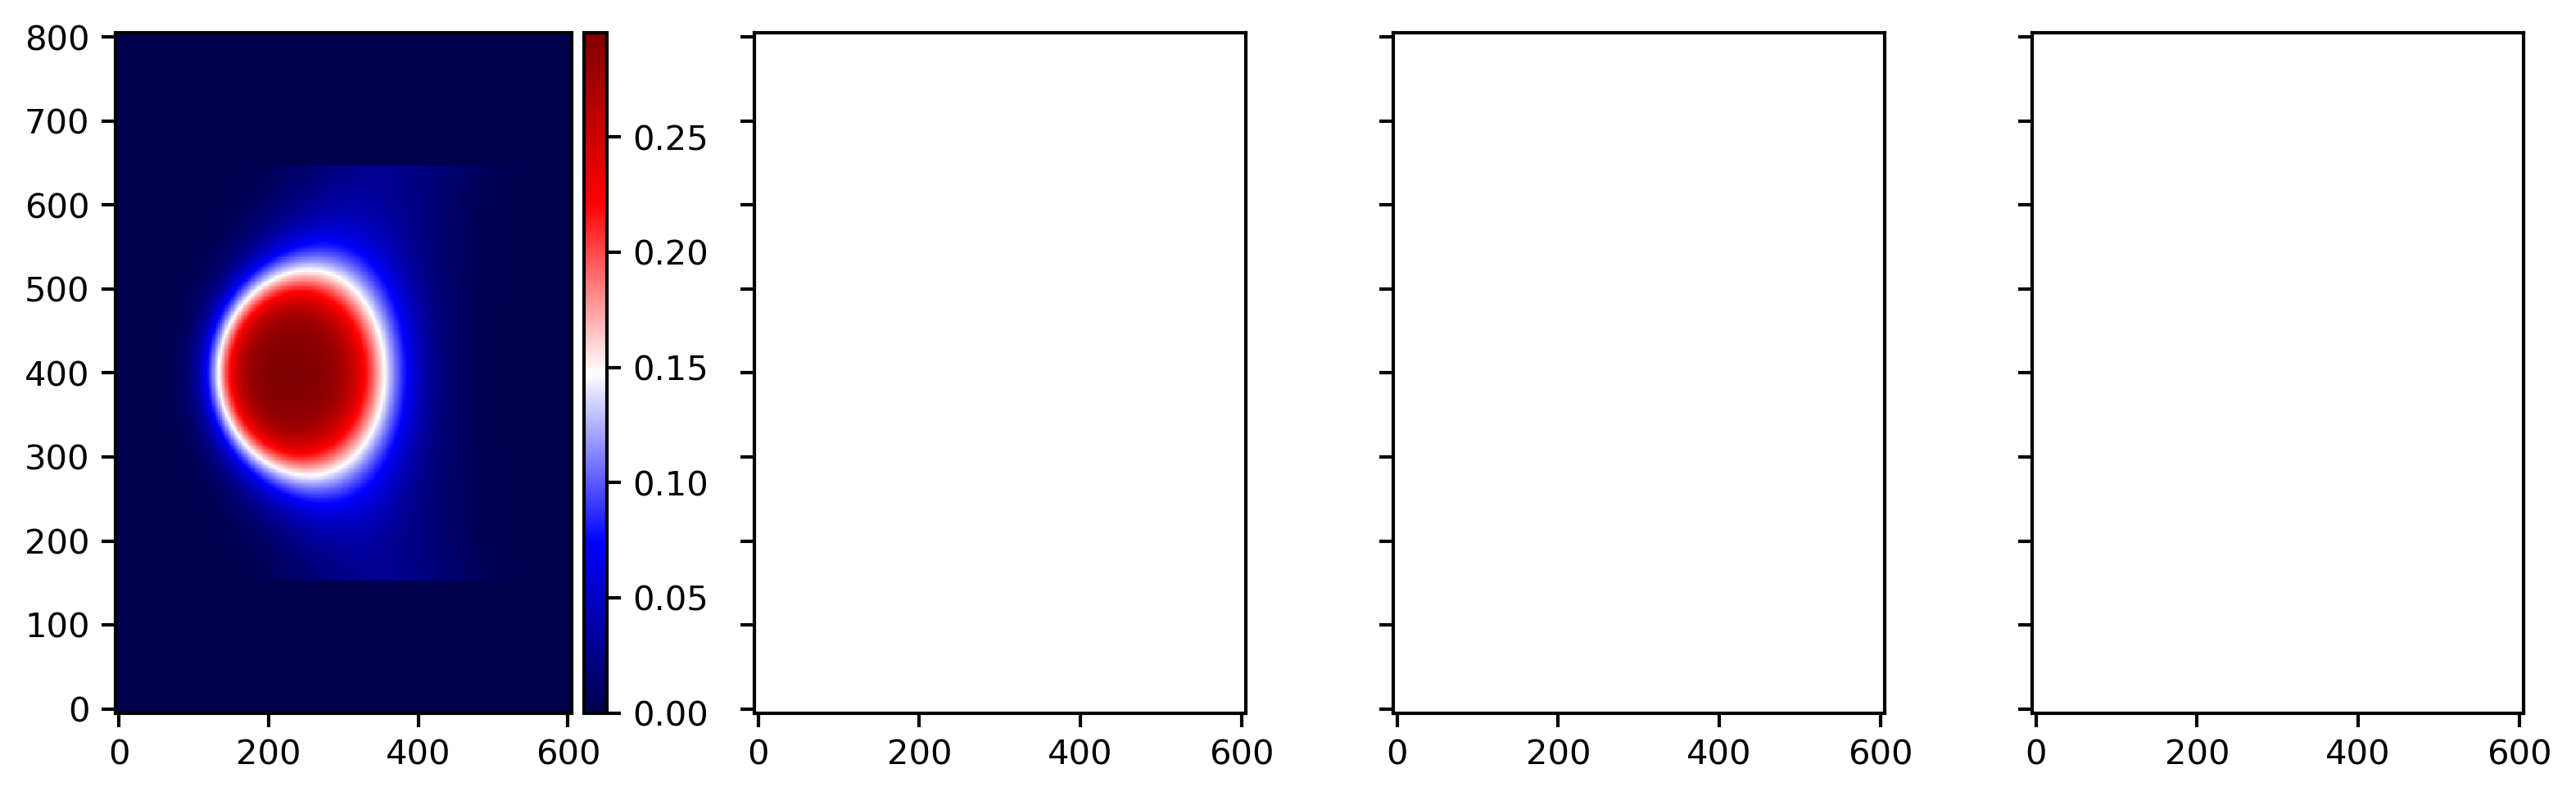

In [27]:
# Assuming 's' is a predefined object with attributes like 'x', 'y', 'Psi', etc.

X, Y = np.meshgrid(s.x, s.y)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(3.5*fig_width, 1.6*fig_height), sharex=True, sharey=True, dpi=300)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)

# Example data for color_maps
titles = [r'$\bar{n}$', r'$\tilde{n}/\bar{n}$', r'$\bar{T}_e}$', r'$\tilde{T}_{e}/\bar{T}_e$']


cs0 = ax[0].pcolormesh(X, Y, Sn, cmap='seismic', rasterized=True)
divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes('right', size='5%', pad=0.05)
cbar0 = fig.colorbar(cs0, cax=cax0, orientation='vertical')
cbar0.ax.tick_params(labelsize=10)  # Adjusted size

cs1 = ax[1].pcolormesh(X, Y, dens_DN_fluct_avg, cmap='seismic', vmin=0., vmax=0.4, rasterized=True)
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(cs1, cax=cax1, orientation='vertical')
cbar1.ax.tick_params(labelsize=10)  # Adjusted size

cs2 = ax[2].pcolormesh(X, Y, St, cmap='seismic', rasterized=True)
divider = make_axes_locatable(ax[2])
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(cs2, cax=cax2, orientation='vertical')
cbar2.ax.tick_params(labelsize=10)  # Adjusted size

cs3 = ax[3].pcolormesh(X, Y, Te_test2, cmap='seismic', vmin=0., vmax=0.3, rasterized=True)
divider = make_axes_locatable(ax[3])
cax3 = divider.append_axes('right', size='5%', pad=0.05)
cbar3 = fig.colorbar(cs3, cax=cax3, orientation='vertical')
cbar3.ax.tick_params(labelsize=10)  # Adjusted size

ax[0].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='w')
ax[1].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='w')
ax[2].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='w')
ax[3].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='w')
for i in range(4):
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].tick_params(axis='both', which='both', direction="in", size=0.5)  # Adjusted size
    ax[i].set_xlabel(r'$R /\rho_{s0}$')
    ax[i].set_title(titles[i])

ax[0].set_ylabel(r'$Z/\rho_{s0}$',rotation=90)
#plt.show()

# Save the figure
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("Snapshot.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=300)

In [18]:
# -*- coding: utf-8 -*-
"""Collection of 3D plotting routines, needs pyvista"""

try:
    import pyvista as pv
except ModuleNotFoundError as _:
    raise ModuleNotFoundError("Cannot load pyvista: for 3D plots install with pip install gbspy[plots3d]") from None

import numpy as np
from .pp import Sim


def plot3d(sim:Sim, data, phi1=None, phi2=None, cmap=None, lights=None, color_psi=None,
           vmax=None, vmin=None, phi_in=None, rho_in=None, vmin_in=None, vmax_in=None,
           window_size_plot=[1200, 900], zoom_val = None):
    """
    Plot the 3D tokamak representation of data, between phi1 and phi2.

    NB: It returns the pyvista.plotter object, allowing to manipulate the orientation, zoom, etc
        and then save it.
        TO CLOSE properly the object use plotter.close() .

    Parameters
    ------------
    gbssim : gbspy.pp.Sim
        Simulation object
    data : np.array 3D,
        Data to plot
    phi1, phi2: float, optional
        Toroidal angle as plot limits
    cmap: str, optional
        Colormap name
    lights: list of pyvista.Light, optional
        list of pyvista.Light objects used in the plot
        NB: default light are thought for default cmap (hot),
            to have no light use: lights = []
            for different light add custom pyvista.Light
    color_psi: str, optional
        color for the separatrix line
    vmin, vmax: float, optional
        Vmin and Vmax for the color plots
    phi_in, rho_in: float, optional
        max angle and rho_psi value to plot an internal surface (0 < rho < 1),
        from phi2 to phi_in.
        If only phi_in is given, psi_in is set to a defulat surface in the core.
    vmin_in, vmax_in: float, optional
        as vmin,vmax but for the inner surface
        NB: The default values for the cmap limits are different for the tokamak plot
            and for the inner surface
    window_size_plot: [x,y] floats, optional
        the size of the window
    zoom_val: float, optional
        value for plotter.camera.zoom, typical good = 1.75
    Returns
    -------
    plotter: pyvista.Plotter,
        plotter where the 3D plot is drawn on,
        possibility to zoom in with plotter.camera.zoom(number>1),
        to save with plotter.save_graphic(filename), etc
    """

    if phi1 is None:
        phi1 = 0
    if phi2 is None:
        phi2 = 4
    if phi2 <= (phi1+sim.dz/2):
        raise ValueError("phi2 has to be larger than phi1+dz/2")

    if cmap is None:
        cmap = 'turbo'

    if color_psi is None:
        color_psi = 'w'

    op_val = 1. #Opacity value
    if vmax is None:
        vmax=np.max(data)
    if vmin is None:
        vmin=np.min(data)

    # Create a plotter
    plotter = pv.Plotter(window_size=window_size_plot)
    plotter.set_background("white")

    iphi1 = np.argmin(np.abs(sim.z-phi1))
    phi1=sim.z[iphi1]
    Z, R = np.meshgrid(sim.y[2:-2], sim.x[2:-2])  # radial and vertical coords
    X1 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.cos(phi1)
    Y1 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.sin(phi1)
    Z1 = Z
    data1 = data[2:-2,2:-2,iphi1]
    data1 = data1.flatten()

    # --- Surface plot 1 (axial cut at phi1)
    grid1 = pv.StructuredGrid(X1, Y1, Z1)
    grid1["values"] = data1
    plotter.add_mesh(grid1, scalars="values", cmap=cmap, clim=[vmin,vmax],
                     opacity=op_val, show_scalar_bar=False, name="plane_phi1")

    grid1["mask"] = sim.Psi[2:-2,2:-2].flatten()
    iso_value = sim.Psi[sim.iyxpt,sim.ixxpt]
    contour_line = grid1.contour(isosurfaces=[iso_value], scalars="mask")
    plotter.add_mesh(contour_line, color=color_psi, line_width=3, name="sep_phi1")

    # --- Surface plot 2 (axial cut at phi2)
    iphi2 = np.argmin(np.abs(sim.z-phi2))
    phi2=sim.z[iphi2]
    X2 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.cos(phi2)
    Y2 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.sin(phi2)
    Z2 = Z
    data2 = data[2:-2,2:-2,iphi2]
    data2 = data2.flatten()
    grid2 = pv.StructuredGrid(X2, Y2, Z2)
    grid2["values"] = data2
    plotter.add_mesh(grid2, scalars="values", cmap=cmap, clim=[vmin,vmax],
                     opacity=op_val, show_scalar_bar=False, name="plane_phi2")

    grid2["mask"] = sim.Psi[2:-2,2:-2].flatten()
    contour_line = grid2.contour(isosurfaces=[iso_value], scalars="mask")
    plotter.add_mesh(contour_line, color=color_psi, line_width=3, name="sep_phi2")


    # --- 2D flux surface bottom
    R, Phi = np.meshgrid(sim.x[2:-2], sim.z[iphi1:iphi2+1])
    X3 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.cos(Phi)
    Y3 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.sin(Phi)
    Z3 = np.ones_like(R)*sim.y[2]
    data3 = data[2,2:-2,iphi1:iphi2+1]
    data3 = data3.flatten()
    grid3 = pv.StructuredGrid(X3, Y3, Z3)
    grid3["values"] = data3
    plotter.add_mesh(grid3, scalars="values", cmap=cmap, clim=[vmin,vmax],
                     opacity=op_val, show_scalar_bar=False, smooth_shading=True,
                     name="bottom_surf")


    # --- 2D flux surface top
    X4 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.cos(Phi)
    Y4 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.sin(Phi)
    Z4 = np.ones_like(R)*sim.y[-3]
    data4 = data[-3,2:-2,iphi1:iphi2+1]
    data4 = data4.flatten()
    grid4 = pv.StructuredGrid(X4, Y4, Z4)
    grid4["values"] = data4
    plotter.add_mesh(grid4, scalars="values", cmap=cmap, clim=[vmin,vmax],
                     opacity=op_val, show_scalar_bar=False, smooth_shading=True,
                     name="top_surf")

    # --- 2D flux surface inner
    Z, Phi = np.meshgrid(sim.y[2:-2], sim.z[iphi1:iphi2+1])
    R = np.zeros_like(Z)
    X5 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.cos(Phi)
    Y5 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.sin(Phi)
    Z5 = Z
    data5 = data[2:-2,2,iphi1:iphi2+1]
    data5 = data5.flatten()
    grid5 = pv.StructuredGrid(X5, Y5, Z5)
    grid5["values"] = data5
    plotter.add_mesh(grid5, scalars="values", cmap=cmap, clim=[vmin,vmax],
                     opacity=op_val, show_scalar_bar=False, smooth_shading=True,
                     name="inner_surf")

    # --- 2D flux surface outer
    R = np.ones_like(Z)*sim.x[-3]
    X6 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.cos(Phi)
    Y6 = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.sin(Phi)
    Z6 = Z
    data6 = data[2:-2,-3,iphi1:iphi2+1]
    data6 = data6.flatten()
    grid6 = pv.StructuredGrid(X6, Y6, Z6)
    grid6["values"] = data6
    plotter.add_mesh(grid6, scalars="values", cmap=cmap, clim=[vmin,vmax],
                     opacity=op_val, show_scalar_bar=False,smooth_shading=True,
                     name="outer_surf")


    #Inside Flux surface
    if phi_in:
        if phi_in <= (phi2+sim.dz/2):
            raise ValueError("phi_in has to be larger than phi2+dz/2")
        rho_vals = (sim.Psi[sim.iy0,sim.ix0:]-sim.Psi[sim.iy0,sim.ix0])/(sim.Psi[sim.iyxpt,sim.ixxpt]-sim.Psi[sim.iy0,sim.ix0])
        if rho_in is None:
            rho_in = 0.85
        ixpsi_in = np.argmin(np.abs(rho_vals-rho_in))+sim.ix0
        iso_value = sim.Psi[sim.iy0,ixpsi_in]
        iphi3 = np.argmin(np.abs(sim.z-phi_in))
        R, Z, Phi = np.meshgrid(sim.x[2:-2], sim.y[2:-2], sim.z[iphi2:iphi3+1])
        X_in = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.cos(Phi)
        Y_in = (R+sim.attribute['rorho_s']-0.5*(sim.x[2]+sim.x[-2])) * np.sin(Phi)
        Z_in = Z
        psi2D = sim.Psi[2:-2,2:-2]
        psi3D = np.repeat(psi2D[:,:,np.newaxis],(iphi3-iphi2+1),axis=2)
        psi3D[Z<sim.yxpt] = 0.
        data_in = data[2:-2,2:-2,iphi2:iphi3+1]
        grid_in = pv.StructuredGrid(X_in,Y_in,Z_in)
        grid_in["Psi"] = psi3D.T.flatten()
        grid_in["values"] = data_in.T.flatten()
        surface_in = grid_in.contour(isosurfaces=[iso_value], scalars="Psi")
        if vmin_in is None:
            vmin_in = np.min(surface_in['values'])
        if vmax_in is None:
            vmax_in = np.max(surface_in['values'])
        plotter.add_mesh(surface_in, scalars="values", cmap=cmap, clim=[vmin_in,vmax_in],
                         show_scalar_bar=False,smooth_shading=True,name="psi_in_surf")


    # --- Camera and lighting
    plotter.view_vector((0, -1, 0.3))

    if lights is None:
        top_light = pv.Light(position=(0, 0, 1), intensity=0.5)
        plotter.add_light(top_light)

        front_light = pv.Light(light_type='headlight',intensity=0.5)
        plotter.add_light(front_light)
    else:
        for light in lights:
            plotter.add_light(light)

    if zoom_val is not None:
        plotter.camera.zoom(zoom_val)

    plotter.show(auto_close=False)
    return plotter



ImportError: attempted relative import with no known parent package